In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

La fonction suivante est basée sur l'hypothèse que les données de "return", ie. r, sont conditionnellement normalement distribuées avec une variance conditionnelle ht estimée par le modèle GARCH.

In [2]:
# Fonction de densité cible (posterior)
def log_posterior(omega1, omega2, omega3, ht, r):
    n = len(r)
    log_likelihood = -0.5 * np.sum(np.log(ht) + r**2 / ht)
    log_prior = norm.logpdf(omega1, loc=0, scale=1) + norm.logpdf(omega2, loc=0, scale=1) + norm.logpdf(omega3, loc=0, scale=1)
    return log_likelihood + log_prior

Comment choisir les paramètres à priori ?

In [3]:
omega_initial=[0.1,0.1,0.3]

Simulation du modèle Garch :

In [4]:
# Simuler les données de rendements
np.random.seed(123)
n = 1000  # Nombre d'observations
epsilon = np.random.normal(loc=0, scale=1, size=n)  # Erreurs aléatoires
ht = np.zeros(n)  # Variance conditionnelle
ht[0] = 1  # Valeur initiale de la variance
r = np.zeros(n)  # Rendements simulés
for i in range(1, n):
    ht[i] = omega_initial[0] + omega_initial[1] * ht[i-1] + omega_initial[2] * r[i-1]**2
    r[i] = epsilon[i] * np.sqrt(ht[i])

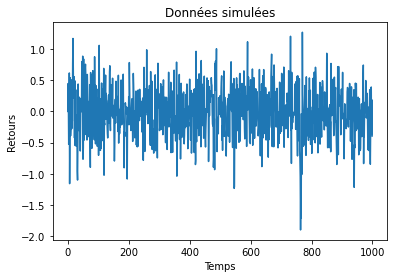

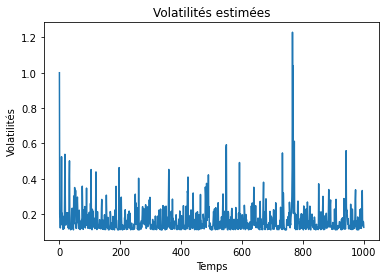

In [5]:
#rendement simulés
plt.plot(r)
plt.title('Données simulées')
plt.xlabel('Temps')
plt.ylabel('Retours')
plt.show()

# volatilités simulées
plt.plot(ht)
plt.title('Volatilités estimées')
plt.xlabel('Temps')
plt.ylabel('Volatilités')
plt.show()

Random Walk Metropolis sampler :

In [6]:
# Fonction d'échantillonnage Random Walk Metropolis
def rwm_sampler(r, n_iter, initial_values, proposal_sd):
    n_params = len(initial_values)
    samples = np.zeros((n_iter, n_params))
    current_values = initial_values
    current_log_posterior = log_posterior(*current_values, ht, r)
    
    for i in range(n_iter):
        # Échantillonnage de la proposition
        proposed_values = [np.random.normal(loc=val, scale=proposal_sd[idx]) for idx, val in enumerate(current_values)]
        
        # Calcul des log-posteriors
        proposed_log_posterior = log_posterior(*proposed_values, ht, r)
        current_log_posterior = log_posterior(*current_values, ht, r)
        
        # Acceptation/rejet de la proposition
        log_acceptance_ratio = proposed_log_posterior - current_log_posterior
        if np.log(np.random.rand()) < log_acceptance_ratio:
            current_values = proposed_values
            current_log_posterior = proposed_log_posterior
        
        samples[i] = current_values
    
    return samples

In [7]:
# Paramètres de l'échantillonneur RWM
n_iter = 10000  # Nombre d'itérations
initial_values = omega_initial  # Valeurs initiales des paramètres
proposal_sd = [0.1, 0.1, 0.1]  # Écart-types des propositions pour chaque paramètre

In [9]:
samples = rwm_sampler(r, n_iter, initial_values, proposal_sd)

# Afficher les résultats
print("Paramètres estimés :")
print("omega1 : ", np.mean(samples[:,0]))
print("omega2 : ", np.mean(samples[:,1]))
print("omega3 : ", np.mean(samples[:,2]))

Paramètres estimés :
omega1 :  0.026163472277052142
omega2 :  -0.1436237199575134
omega3 :  0.0902945146270586
